In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Load the train, validation, and test splits
#train_iter, val_iter, test_iter = WikiText2()



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Tom\miniconda3\envs\MLX-1\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\Tom\miniconda3\envs\MLX-1\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Tom\miniconda3\envs\MLX-1\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users

In [2]:
from datasets import load_dataset

# Load the dataset (raw text version)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_iter = dataset['train']['text']


In [3]:
# subset
# train_iter = dataset['train'].select(range(1000))['text']


In [3]:
type(train_iter)

list

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import DataLoader, Dataset


In [6]:

# 1. Load  WikiText
tokenizer = get_tokenizer('basic_english')


In [7]:

# Build vocabulary
counter = Counter()
for line in train_iter:
    counter.update(tokenizer(line))
vocab = {word: i for i, (word, _) in enumerate(counter.items())}
vocab_size = len(vocab)


In [8]:
len(vocab)

66057

In [9]:
# example
first_key = next(iter(vocab))
first_value = vocab[first_key]

print(f"First key: {first_key}, First value: {first_value}")

First key: =, First value: 0


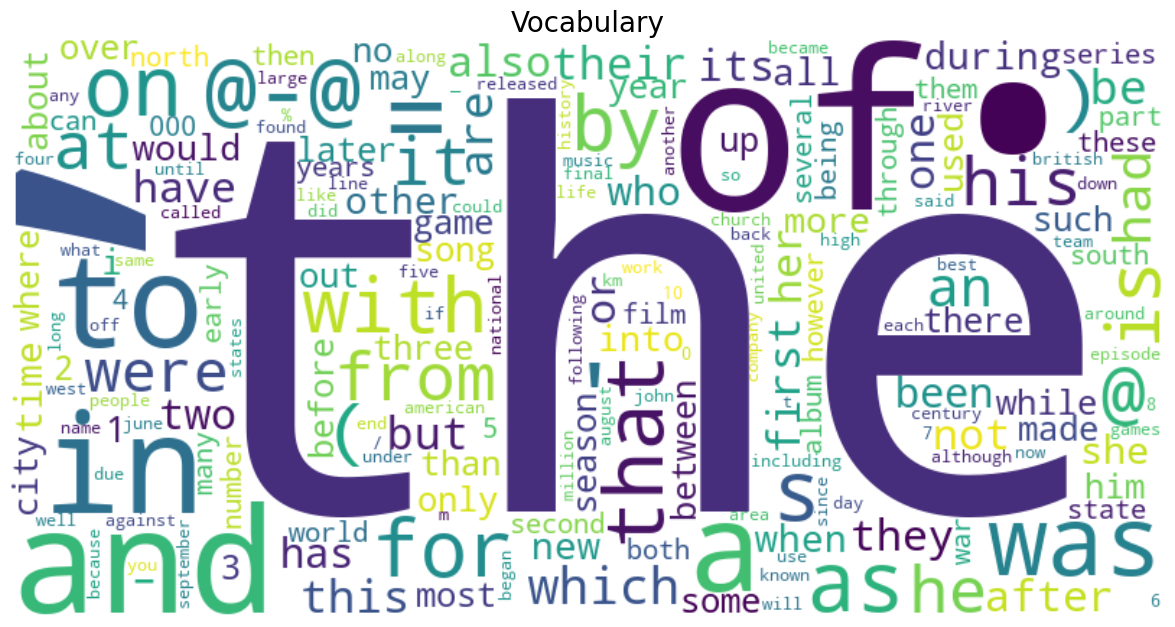

In [ ]:
# Wordcloud visualisation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Vocabulary", fontsize=20)
plt.show()


In [11]:

CONTEXT_SIZE = 2
data = []
for line in train_iter:
    tokens = tokenizer(line)
    if len(tokens) < 2 * CONTEXT_SIZE + 1:
        continue  # skip short lines
    for i in range(CONTEXT_SIZE, len(tokens) - CONTEXT_SIZE):
        context = [tokens[j] for j in range(i - CONTEXT_SIZE, i)] + \
                  [tokens[j] for j in range(i + 1, i + CONTEXT_SIZE + 1)]
        target = tokens[i]
        data.append((context, target))


class CBOWDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        context, target = self.data[idx]
        context_idxs = torch.tensor([self.vocab[w] for w in context], dtype=torch.long)
        target_idx = torch.tensor(self.vocab[target], dtype=torch.long)
        return context_idxs, target_idx

dataset = CBOWDataset(data, vocab)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


# 2. Define model
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
    def forward(self, context_idxs):
        embeds = self.embeddings(context_idxs)
        avg_embeds = embeds.mean(dim=1)
        out = self.linear(avg_embeds)
        return out
    def get_embedding(self, words, vocab):
        idxs = torch.tensor([vocab[w] for w in words if w in vocab], dtype=torch.long)
        return self.embeddings(idxs)


In [12]:

# 3. Train
embedding_dim = 24
model = CBOWModel(vocab_size, embedding_dim)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(2):  # TEMP
    print("epoch", epoch, "start")
    total_loss = 0
    for context_idxs, target_idx in dataloader:
        model.zero_grad()
        log_probs = model(context_idxs)
        loss = loss_function(log_probs, target_idx)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss}")


epoch 0
Epoch 0, Loss: 154676.45158576965
epoch 1
Epoch 1, Loss: 138088.0151538849


In [13]:

# 4. Get embeddings for a string
def get_string_embedding(model, input_string, vocab):
    tokens = tokenizer(input_string)
    with torch.no_grad():
        embedding = model.get_embedding(tokens, vocab)
    return embedding


In [15]:

# Example
embedding = get_string_embedding(model, "Hacker news", vocab)
print(embedding)


tensor([[-0.7217,  1.4253,  1.8063,  2.4197,  2.4341, -0.3875, -0.7809,  0.8559,
          1.2859,  1.5514,  0.0482, -0.0851,  1.0648,  1.5471, -0.2750,  1.3542,
         -1.4907, -0.9085,  0.8525, -0.2069, -3.2042, -0.2748,  0.4548, -1.6605],
        [-0.9154,  0.1030, -0.5849, -0.9963, -0.5091,  0.5573, -1.0291,  1.1908,
         -0.4858, -0.1015, -1.4254,  1.3058, -1.0689,  1.3891, -0.3815,  0.6549,
         -0.3146, -0.8795, -0.2957, -0.1484, -0.4968, -1.3290, -0.0878, -0.8141]])
